# Loading and Wrangling Data

Loading in data using the functions that we made:

In [82]:
oneBatch = False

In [83]:
# Run if you want one batch
import data_loading as dt
import os


if oneBatch:
    batchNum = 1
    if os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
        ids, images = dt.importImages(f'batch{batchNum}/part_{batchNum}/')
    else:
        ids, images = dt.loadImageBatch(batchNum)
else:
    #batchNums = list(range(1,13))
    batchNums = [2, 7, 10]
    ids, images = dt.loadImageBatches(batchNums)

2
7
10


Getting annotations and getting them into the correct order:

In [84]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [85]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [86]:
labels[0:20]

[4, 4, 7, 3, 8, 7, 8, 7, 8, 3, 4, 3, 4, 7, 8, 8, 7, 8, 4, 3]

Converting images to tensors:

In [87]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net

## Creating Neural Net

In [88]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

# CNN
from torch import nn
import torchvision
class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,8,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,16,2,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,3,1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5408, 200),
            nn.ReLU(),
            nn.Linear(200, 18)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

## Training Neural Net

Train-test split:

In [89]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)

In [90]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
epochs = 300
lrate = 0.001
bsize = 32

# For reproducibility
torch.manual_seed(3)

# Cost Function
cost_fn = nn.CrossEntropyLoss()

# Initialize the model
net = my_net()

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

# Make DataLoader
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor),
                                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

# Training loop
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Transform the input data using our data augmentation strategies
        inputs = data_transforms(inputs)

        # Forward, backward, and optimize
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(outputs, labels)  # CrossEntropyLoss already applies Softmax
        cost.backward()
        optimizer.step()

        cur_cost += cost.item()

    # Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(epoch/epochs)
    #print(f"Epoch: {epoch} Cost: {cur_cost}")

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


Calculating training accuracy:

In [91]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.9667908131595282


Calculating testing accuracy:

In [92]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=bsize)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")

Test Accuracy is 0.9587656291566906


In [99]:
set(train_y)

{0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 15, 16, 17}

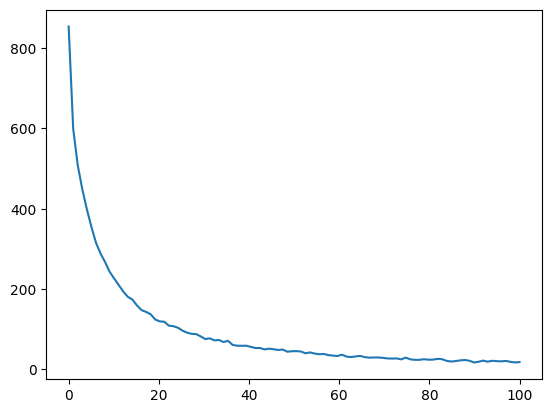

In [93]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [100]:
torch.save(net.state_dict(), 'model1_weights.pth')